In [8]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from tqdm import trange
from torch import Tensor

torch.set_default_device("cuda")
DEVICE = torch.get_default_device()
DEVICE

device(type='cuda', index=0)

In [9]:
# Define GAN model

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 64, 4, 2, 1)
        self.conv3 = nn.Conv2d(64, 64, 4, 2, 1)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(64)
        self.lin = nn.Linear(64 * 8 * 8, 1)

    def forward(self, x: Tensor) -> Tensor:
        x = F.leaky_relu(self.bn1(self.conv1(x)), negative_slope=0.2)
        x = F.leaky_relu(self.bn2(self.conv2(x)), negative_slope=0.2)
        x = F.leaky_relu(self.bn3(self.conv3(x)), negative_slope=0.2)
        x = x.flatten(1)
        x = self.lin(x)
        return x


class Generator(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.lin = nn.Linear(latent_dim, 64 * 8 * 8)
        self.conv1 = nn.Conv2d(64, 64, 3, 1, 1)
        self.conv2 = nn.Conv2d(64, 128, 3, 1, 1)
        self.conv3 = nn.Conv2d(128, 256, 3, 1, 1)
        self.conv4 = nn.Conv2d(256, 3, 5, 1, 2)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)

    def forward(self, x: Tensor) -> Tensor:
        x = self.lin(x)
        x = x.reshape(-1, 64, 8, 8)
        x = F.leaky_relu(self.bn1(self.conv1(F.interpolate(x, scale_factor=2))), negative_slope=0.2)
        x = F.leaky_relu(self.bn2(self.conv2(F.interpolate(x, scale_factor=2))), negative_slope=0.2)
        x = F.leaky_relu(self.bn3(self.conv3(F.interpolate(x, scale_factor=2))), negative_slope=0.2)
        x = F.tanh(self.conv4(x))
        return x

# Define helper functions

def make_batch(imgs: np.ndarray, batch_size: int):
    samples = np.random.choice(len(imgs), (len(imgs) // batch_size, batch_size), replace=False)
    for sample in samples:
        yield Tensor(imgs[sample, ...]).float().to(DEVICE)


def show(imgs: Tensor, savepath: str | None = None):
    B, *_ = imgs.shape
    # Normalize values from [-1;+1] to [0;1]
    imgs = (imgs + 1.0) / 2.0

    ncols = int(np.sqrt(B))
    nrows = int(np.ceil(B / ncols))
    fig = plt.figure(figsize=(9, 9))

    for b in range(B):
        fig.add_subplot(nrows, ncols, b + 1)
        plt.axis("off")
        plt.imshow(imgs[b, ...].permute(1, 2, 0).cpu().numpy())

    if savepath is not None:
        plt.savefig(savepath, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

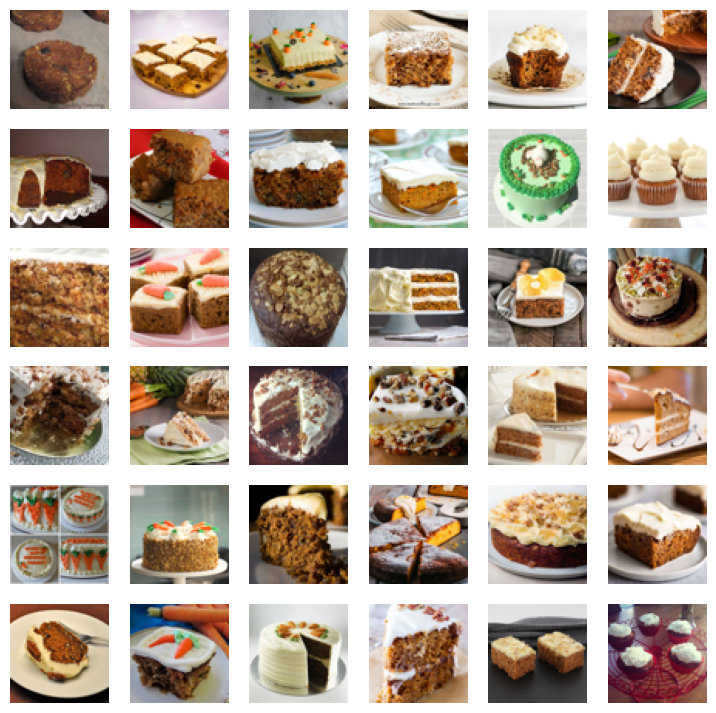

In [10]:
# Load data

dirname = "./crawled_cakes"
imgs_dataset = np.array([Image.open(f"{dirname}/{f}").convert("RGB").resize((64, 64)) for f in os.listdir(dirname)])
imgs_dataset = imgs_dataset.transpose(0, 3, 1, 2)
imgs_dataset = imgs_dataset.astype(np.float32)
imgs_dataset = (imgs_dataset / 127.5) - 1.0

show(next(make_batch(imgs_dataset, 36)))

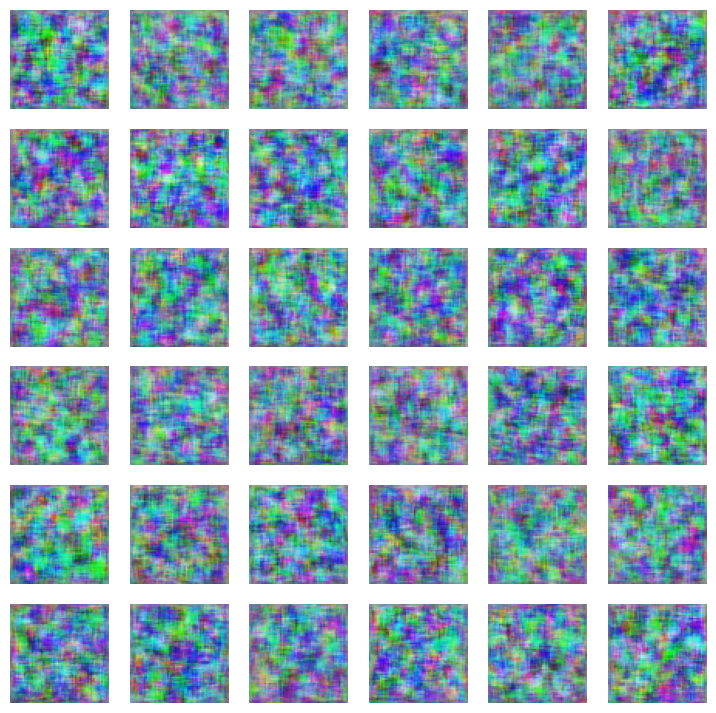

In [15]:
# Define training parameters

batch_size = 16
log_period = 50
epochs = 3_000

G = Generator(latent_dim := 128)
D = Discriminator()

criterion = F.binary_cross_entropy_with_logits

optim_g = optim.AdamW(G.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=1e-2)
optim_d = optim.AdamW(D.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=1e-2)

fixed_noise = torch.randn(36, latent_dim)
show(G(fixed_noise).detach())

In [ ]:
hist_loss = {"G": [], "D": []}
os.makedirs("./outputs/", exist_ok=True)
os.makedirs("./checkpoints/", exist_ok=True)

# Training loop
for epoch in (pbar := trange(epochs)):
    running_loss_g = 0.0
    running_loss_d = 0.0

    for X_real in make_batch(imgs_dataset, batch_size):
        # TRAIN DISCRIMINATOR
        # =============================
        optim_d.zero_grad()

        # Train discriminator with real images
        t_real = torch.ones(batch_size, 1)
        y_real = D(X_real)

        # Train discriminator with fake images
        noise = torch.randn(batch_size, latent_dim)
        X_fake: Tensor = G(noise)

        t_fake = torch.zeros(batch_size, 1)
        y_fake = D(X_fake.detach())

        loss_d = criterion(y_real, t_real) + criterion(y_fake, t_fake)
        loss_d.backward()

        optim_d.step()

        # TRAIN GENERATOR
        # =============================
        optim_g.zero_grad()

        t_adver = torch.ones(batch_size, 1)
        y_adver = D(X_fake)

        loss_g = criterion(y_adver, t_adver)
        loss_g.backward()

        optim_g.step()

        running_loss_g += loss_g.item()
        running_loss_d += loss_d.item()

    epoch_loss_g = (running_loss_g * batch_size) / len(imgs_dataset)
    epoch_loss_d = (running_loss_d * batch_size) / len(imgs_dataset)

    hist_loss["G"].append(epoch_loss_g)
    hist_loss["D"].append(epoch_loss_d)

    pbar.set_description(f"Epoch [{epoch+1}/{epochs}] | G Loss: {epoch_loss_g:.4f} | D Loss: {epoch_loss_d:.4f}")

    # Print losses
    if (epoch + 1) % log_period == 0:
        show(G(fixed_noise).detach(), savepath=f"./outputs/img{epoch+1}.png")
        torch.save(
            {
                "epoch": epoch + 1,
                "G_state_dict": G.state_dict(),
                "D_state_dict": D.state_dict(),
                "optim_g_state": optim_g.state_dict(),
                "optim_d_state": optim_d.state_dict(),
            },
            f"./checkpoints/params_epoch{epoch+1}.pt",
        )
        with open(f"./checkpoints/loss_epoch{epoch+1}.pickle", "wb") as file:
            pickle.dump(hist_loss, file, protocol=pickle.HIGHEST_PROTOCOL)

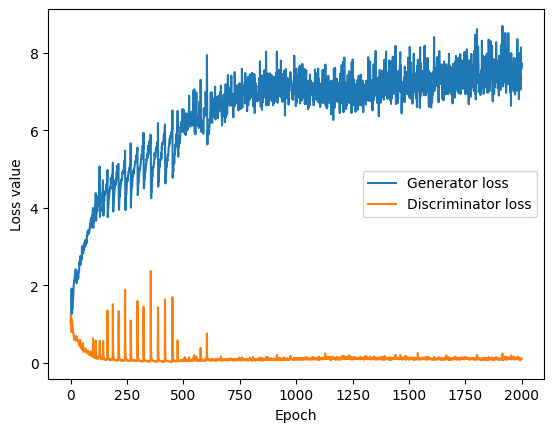

In [2]:
with open("checkpoints/loss_epoch2000.pickle", "rb") as file:
    loss_hist = pickle.load(file)

plt.plot(loss_hist["G"], label="Generator loss")
plt.plot(loss_hist["D"], label="Discriminator loss")
plt.xlabel("Epoch")
plt.ylabel("Loss value")
plt.legend(loc="best")
plt.show()

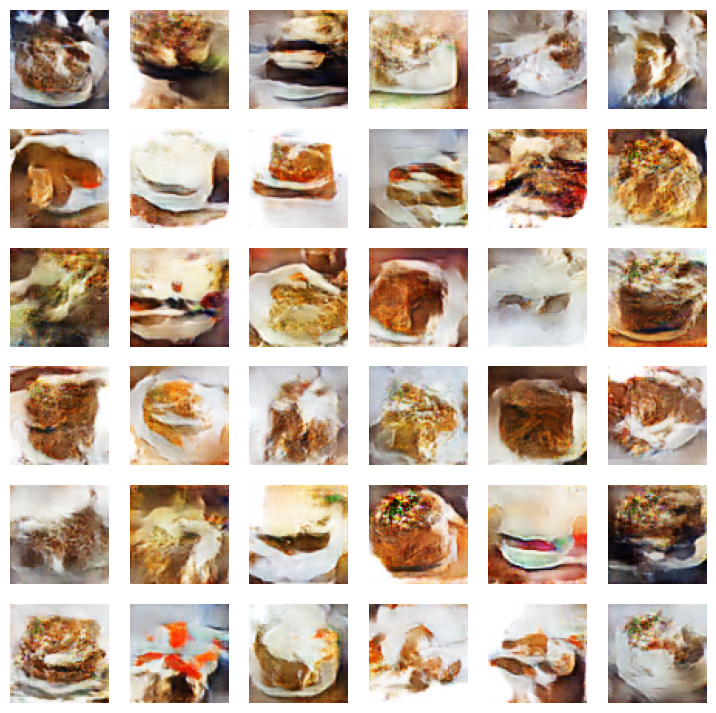

In [3]:
params = torch.load("checkpoints/params_epoch500.pt", weights_only=False)
G = Generator()
G.load_state_dict(params["G_state_dict"])

show(G(torch.randn(36, 128)).detach())

In [4]:
def find_latent(target_img: Tensor, save_intermediate: str | None = None) -> Tensor:
    if save_intermediate is not None:
        os.makedirs(save_intermediate, exist_ok=True)

    epochs = 10_000
    log_period = 100

    noise = torch.randn(1, 128)
    noise.requires_grad = True
    criterion = F.mse_loss
    optimizer = optim.SGD([noise], lr=1e-1, momentum=0.99, nesterov=True)

    for epoch in (pbar := trange(epochs)):
        optimizer.zero_grad()
        fake_img = G(noise)
        loss = criterion(fake_img, target_img)
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Loss {loss.item():.4f}")
        if (epoch in range(100) or (epoch + 1) % log_period == 0) and save_intermediate is not None:
            show(fake_img.detach(), savepath=f"{save_intermediate}/img_{epoch+1}.jpg")

    return noise

Loss 0.0608: 100%|██████████| 10000/10000 [00:55<00:00, 181.69it/s]


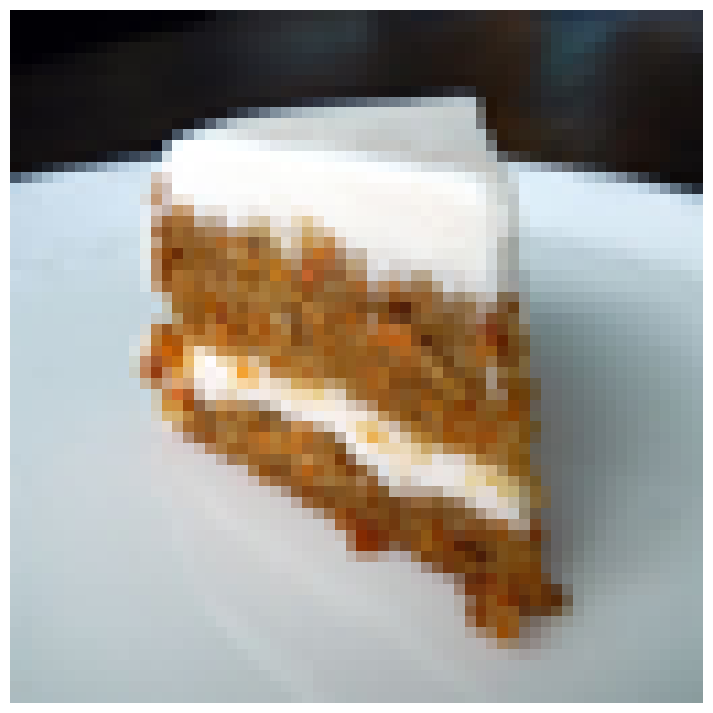

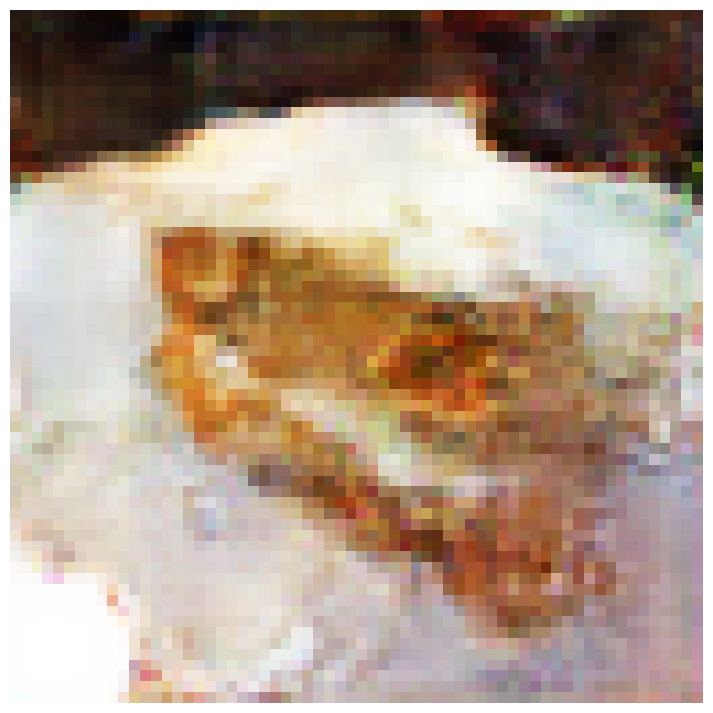

In [5]:
target_img_cake1 = np.array(Image.open("crawled_cakes/027_99511daa.jpg").convert("RGB").resize((64, 64)))
target_img_cake1 = target_img_cake1.transpose(2, 0, 1)
target_img_cake1 = target_img_cake1.astype(np.float32)
target_img_cake1 = (target_img_cake1 / 127.5) - 1.0
target_img_cake1 = Tensor(target_img_cake1).unsqueeze(0).float().to(DEVICE)

latent_cake_1 = find_latent(target_img_cake1, save_intermediate="./out_noise_1")

show(target_img_cake1)
show(G(latent_cake_1).detach())

Loss 0.2615: 100%|██████████| 10000/10000 [00:45<00:00, 220.32it/s]


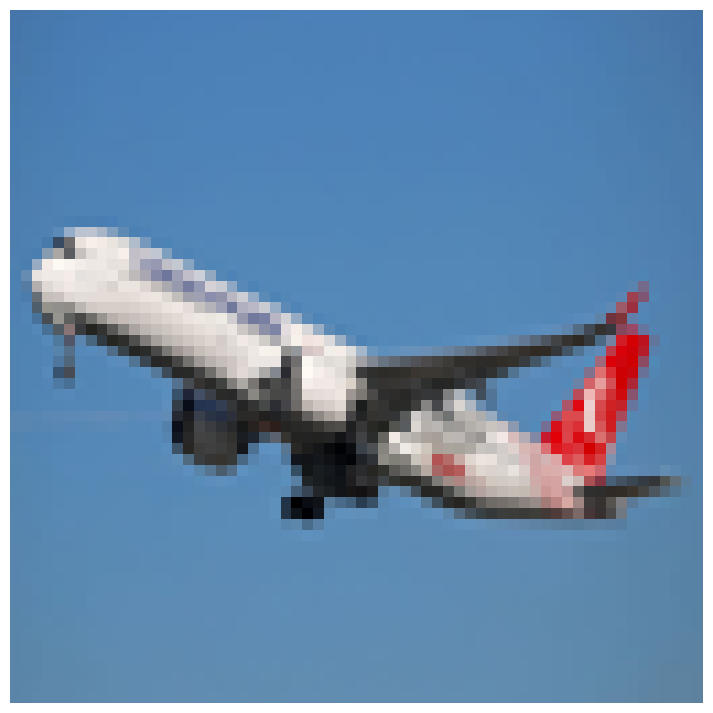

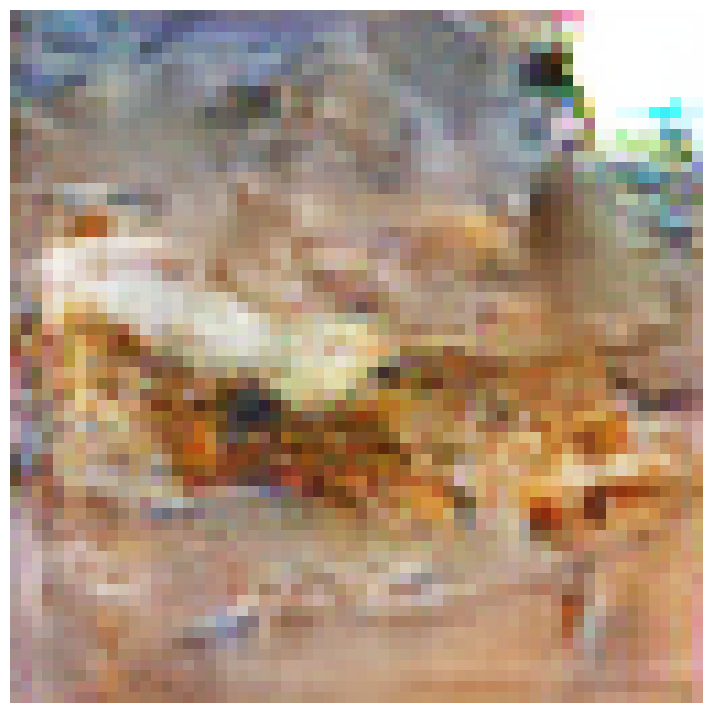

In [ ]:
target_img_plane = np.array(Image.open("./other/plane.png").convert("RGB").resize((64, 64)))
target_img_plane = target_img_plane.transpose(2, 0, 1)
target_img_plane = target_img_plane.astype(np.float32)
target_img_plane = (target_img_plane / 127.5) - 1.0
target_img_plane = Tensor(target_img_plane).unsqueeze(0).float().to(DEVICE)

latent_plane = find_latent(target_img_plane)

show(target_img_plane)
show(G(latent_plane).detach())

Loss 0.0547: 100%|██████████| 10000/10000 [00:54<00:00, 183.86it/s]


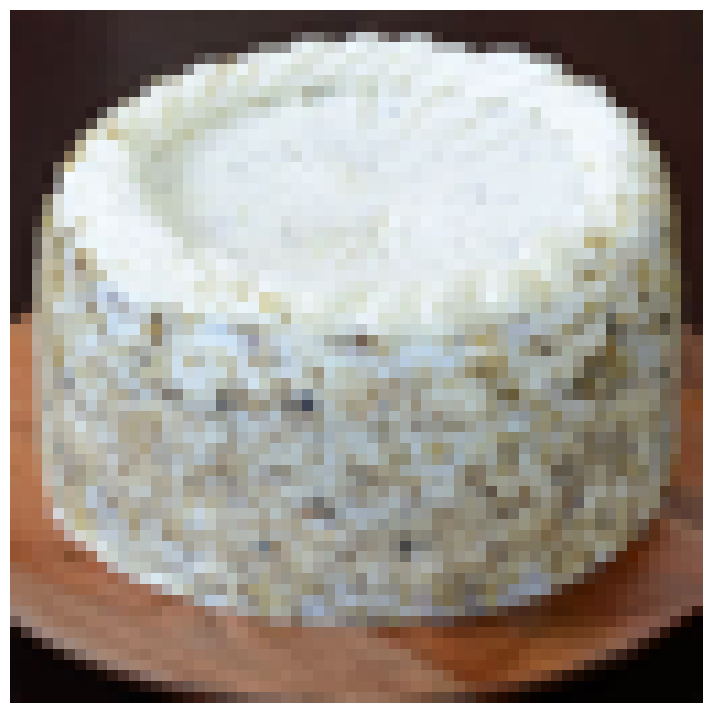

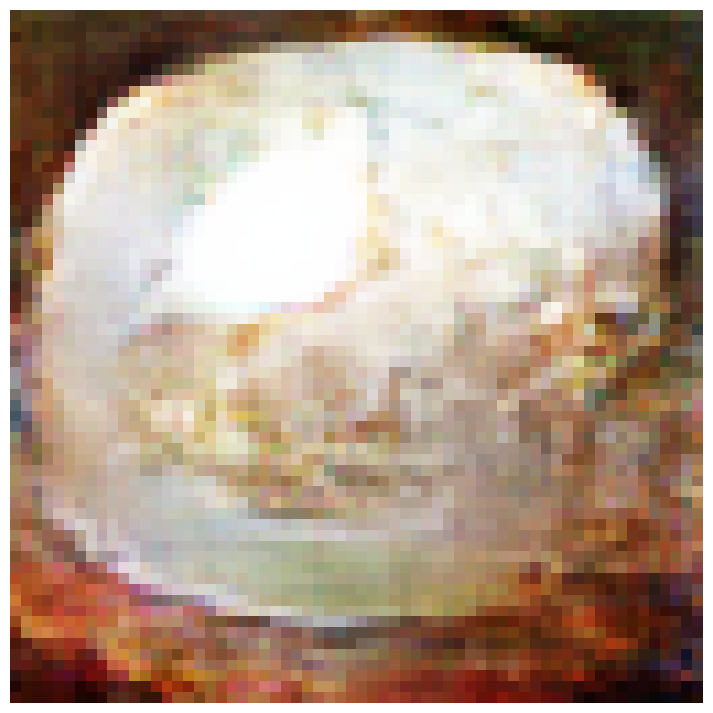

In [7]:
target_img_cake2 = np.array(Image.open("crawled_cakes/039_d8bd02ed.jpg").convert("RGB").resize((64, 64)))
target_img_cake2 = target_img_cake2.transpose(2, 0, 1)
target_img_cake2 = target_img_cake2.astype(np.float32)
target_img_cake2 = (target_img_cake2 / 127.5) - 1.0
target_img_cake2 = Tensor(target_img_cake2).unsqueeze(0).float().to(DEVICE)

latent_cake_2 = find_latent(target_img_cake2, save_intermediate="./out_noise_2")

show(target_img_cake2)
show(G(latent_cake_2).detach())

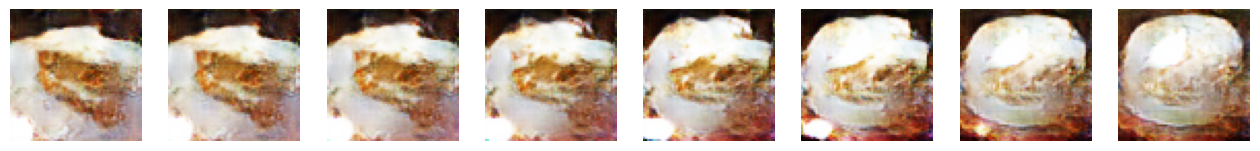

In [18]:
latent_cake_intermediate = lambda alpha: latent_cake_1 + alpha * (latent_cake_2 - latent_cake_1)

fig = plt.figure(figsize=(16, 16))
ncols, nrows, idx = 8, 1, 1

for alpha in np.linspace(0, 1, ncols):
    im: Tensor = G(latent_cake_intermediate(alpha)).detach()
    im = (im + 1.0) / 2.0
    fig.add_subplot(nrows, ncols, idx)
    idx += 1
    plt.axis("off")
    plt.imshow(im[0, ...].permute(1, 2, 0).cpu().numpy())